In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('Global Cybersecurity Threats 2015-2024.csv')

# Basic data info
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Time Period: {df['Year'].min()} to {df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")
print(f"Industries: {df['Target Industry'].nunique()}")

Dataset Shape: (3000, 10)
Columns: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)']
Time Period: 2015 to 2024
Countries: 10
Industries: 7


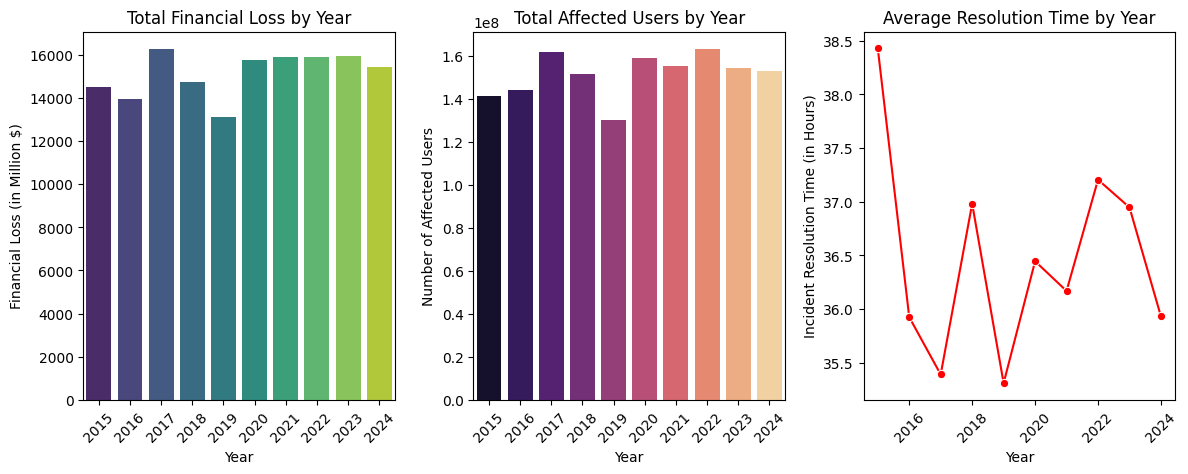

In [9]:
# Yearly attack trends
yearly_stats = df.groupby('Year').agg({
    'Financial Loss (in Million $)': 'sum',
    'Number of Affected Users': 'sum',
    'Incident Resolution Time (in Hours)': 'mean'
}).reset_index()

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=yearly_stats, x='Year', y='Financial Loss (in Million $)', palette='viridis')
plt.title('Total Financial Loss by Year')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(data=yearly_stats, x='Year', y='Number of Affected Users', palette='magma')
plt.title('Total Affected Users by Year')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.lineplot(data=yearly_stats, x='Year', y='Incident Resolution Time (in Hours)', marker='o', color='red')
plt.title('Average Resolution Time by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('yearly_trends.png', dpi=300, bbox_inches='tight')

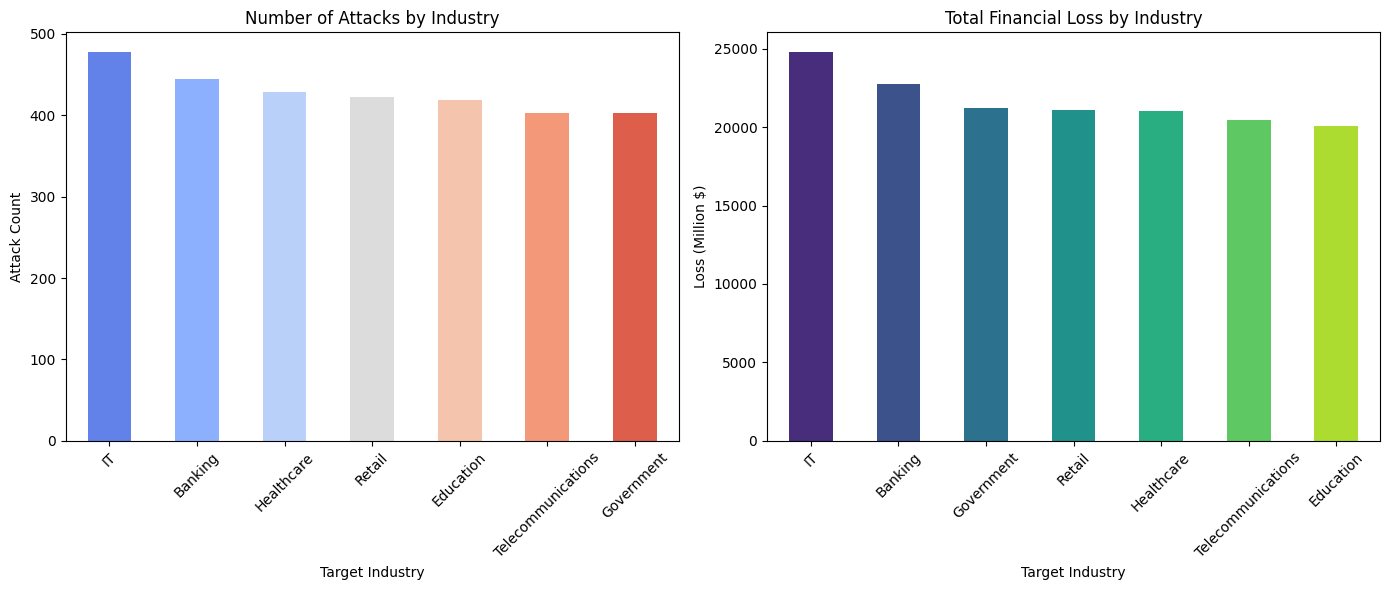

In [10]:
# Industry analysis
industry_stats = df.groupby('Target Industry').agg({
    'Financial Loss (in Million $)': ['sum', 'mean', 'count']
}).round(2)

# Create visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
industry_counts = df['Target Industry'].value_counts()
industry_counts.plot(kind='bar', color=sns.color_palette('coolwarm', len(industry_counts)))
plt.title('Number of Attacks by Industry')
plt.ylabel('Attack Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
industry_loss = df.groupby('Target Industry')['Financial Loss (in Million $)'].sum().sort_values(ascending=False)
industry_loss.plot(kind='bar', color=sns.color_palette('viridis', len(industry_loss)))
plt.title('Total Financial Loss by Industry')
plt.ylabel('Loss (Million $)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('industry_analysis.png', dpi=300, bbox_inches='tight')

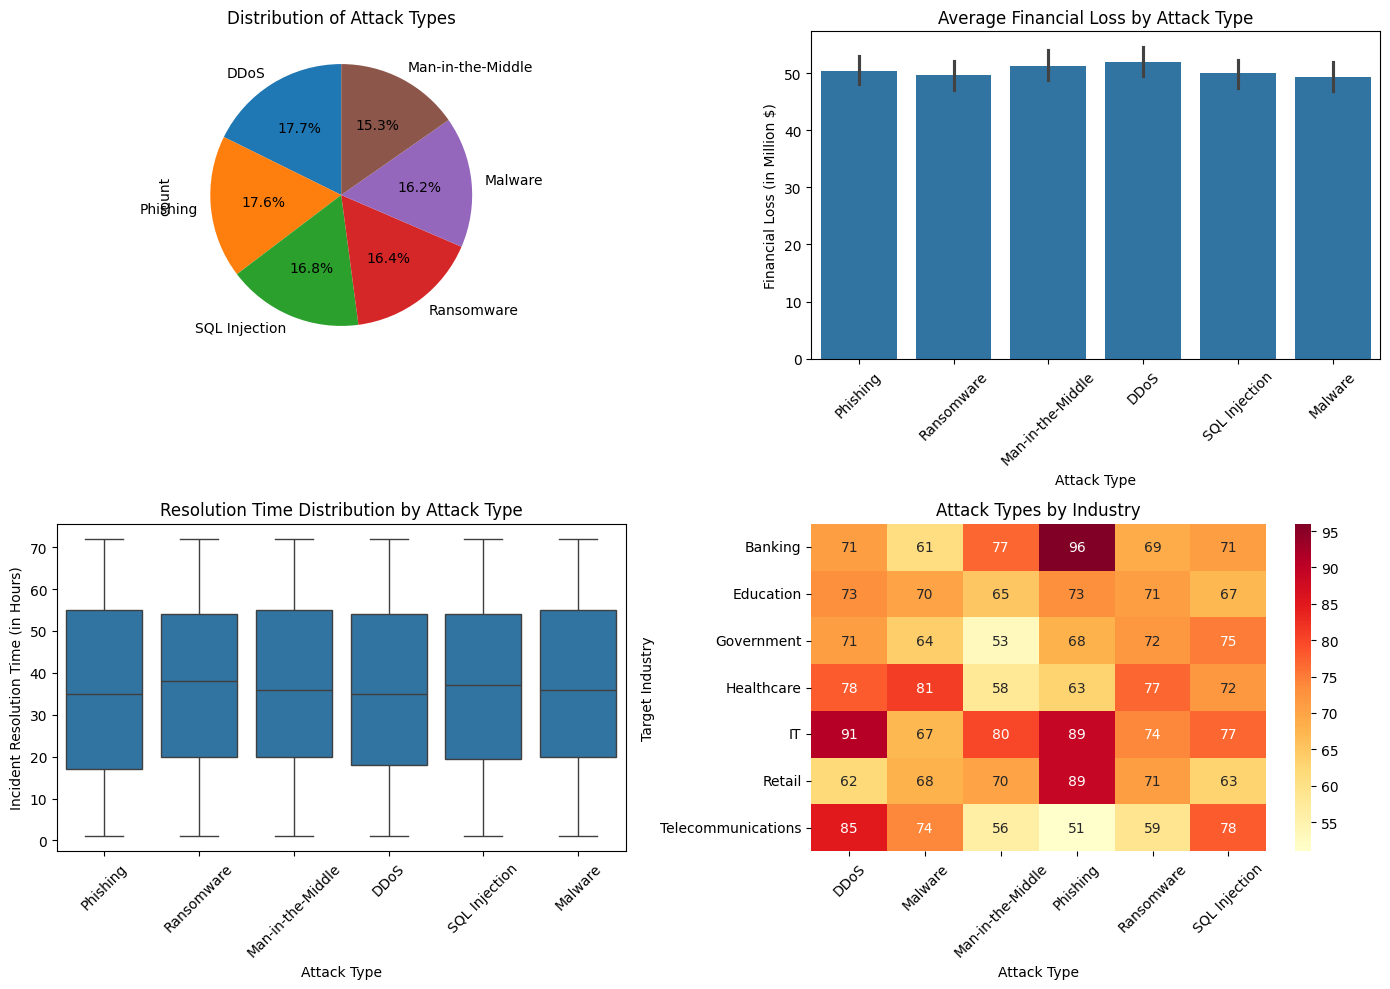

In [11]:
# Attack type analysis
attack_stats = df.groupby('Attack Type').agg({
    'Financial Loss (in Million $)': 'mean',
    'Incident Resolution Time (in Hours)': 'mean',
    'Country': 'count'
}).rename(columns={'Country': 'Attack Count'})

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Attack frequency
df['Attack Type'].value_counts().plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution of Attack Types')

# Financial impact by attack type
sns.barplot(data=df, x='Attack Type', y='Financial Loss (in Million $)', ax=axes[0, 1], estimator='mean')
axes[0, 1].set_title('Average Financial Loss by Attack Type')
axes[0, 1].tick_params(axis='x', rotation=45)

# Resolution time by attack type
sns.boxplot(data=df, x='Attack Type', y='Incident Resolution Time (in Hours)', ax=axes[1, 0])
axes[1, 0].set_title('Resolution Time Distribution by Attack Type')
axes[1, 0].tick_params(axis='x', rotation=45)

# Heatmap of attack types by industry
attack_industry = pd.crosstab(df['Target Industry'], df['Attack Type'])
sns.heatmap(attack_industry, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Attack Types by Industry')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('attack_type_analysis.png', dpi=300, bbox_inches='tight')

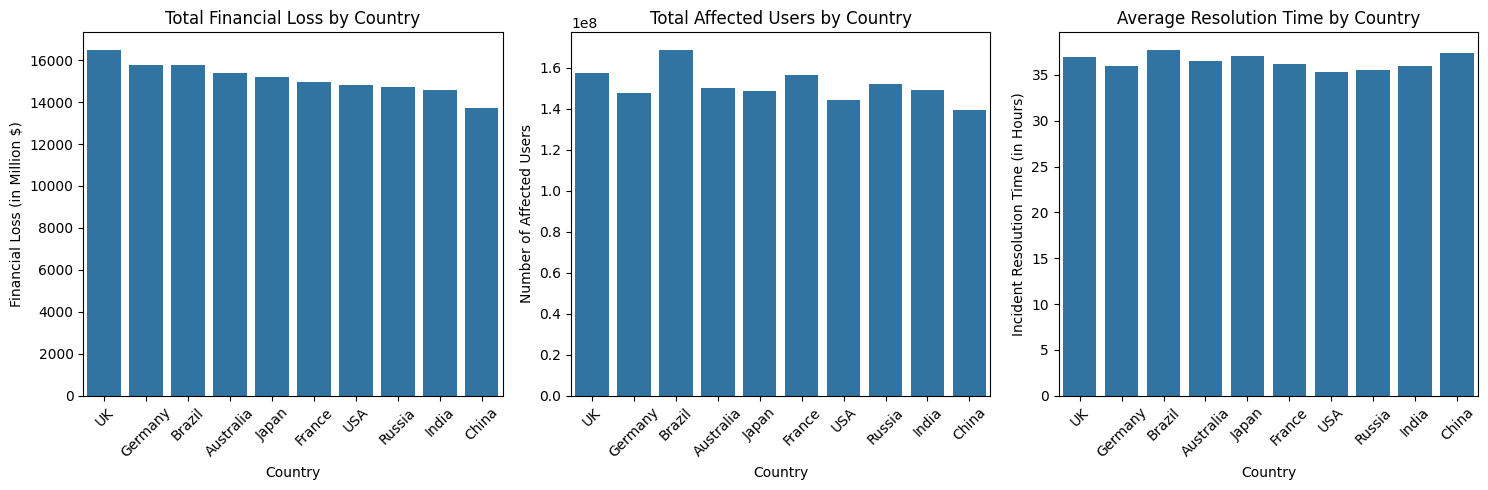

In [12]:
# Country analysis
country_stats = df.groupby('Country').agg({
    'Financial Loss (in Million $)': 'sum',
    'Number of Affected Users': 'sum',
    'Incident Resolution Time (in Hours)': 'mean'
}).sort_values('Financial Loss (in Million $)', ascending=False)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=country_stats.index, y=country_stats['Financial Loss (in Million $)'])
plt.title('Total Financial Loss by Country')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x=country_stats.index, y=country_stats['Number of Affected Users'])
plt.title('Total Affected Users by Country')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x=country_stats.index, y=country_stats['Incident Resolution Time (in Hours)'])
plt.title('Average Resolution Time by Country')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('country_analysis.png', dpi=300, bbox_inches='tight')

Model Performance:
Mean Absolute Error: $25.10 Million
R-squared Score: -0.065


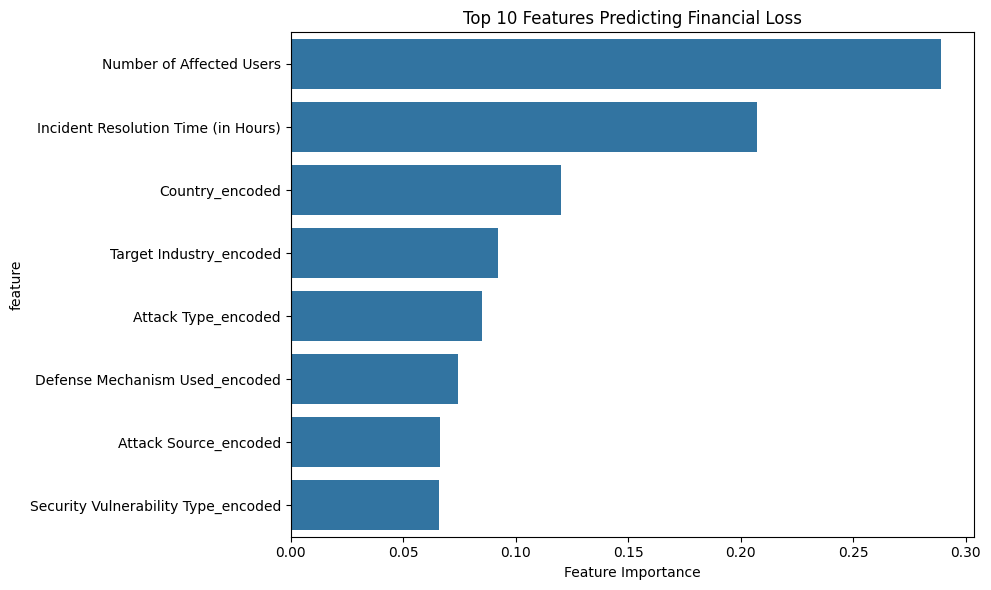

In [13]:
# Prepare data for machine learning
df_ml = df.copy()

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 
                    'Security Vulnerability Type', 'Defense Mechanism Used']

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[col + '_encoded'] = le.fit_transform(df_ml[col])
    label_encoders[col] = le

# Features and target
X = df_ml[[col + '_encoded' for col in categorical_cols] + 
          ['Number of Affected Users', 'Incident Resolution Time (in Hours)']]
y = df_ml['Financial Loss (in Million $)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"Mean Absolute Error: ${mae:.2f} Million")
print(f"R-squared Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features Predicting Financial Loss')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

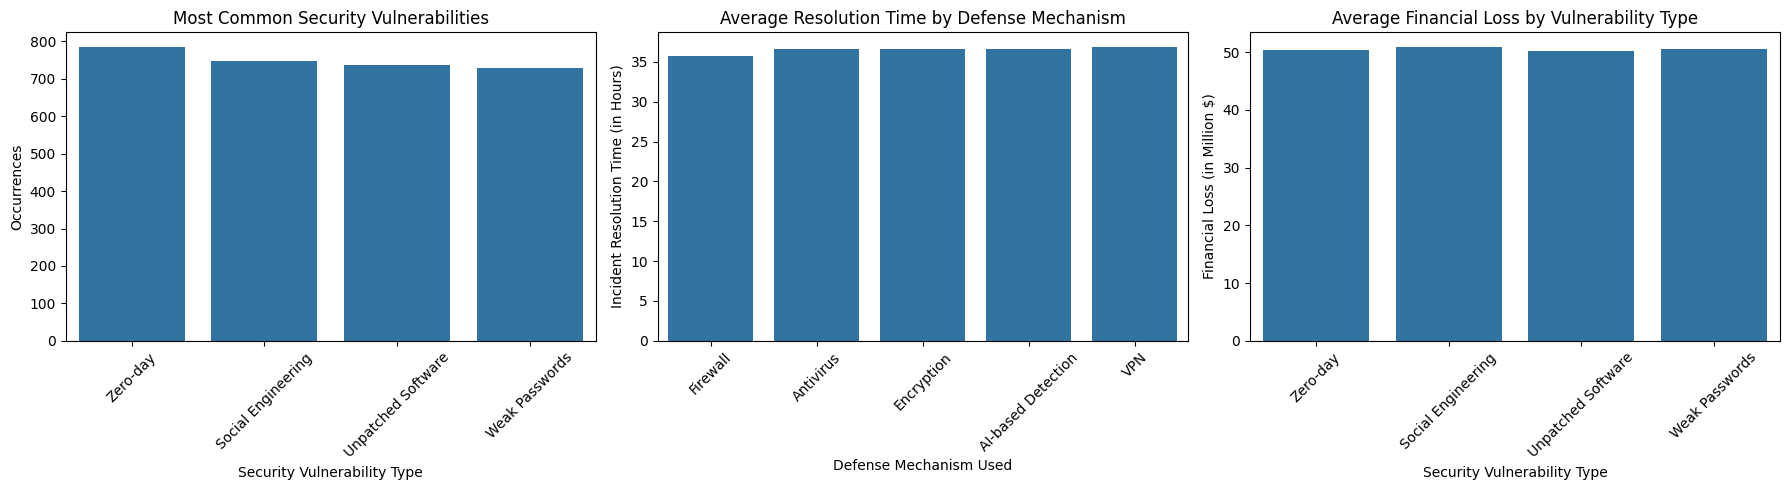

In [14]:
# Vulnerability analysis
vuln_analysis = df.groupby('Security Vulnerability Type').agg({
    'Financial Loss (in Million $)': 'mean',
    'Incident Resolution Time (in Hours)': 'mean',
    'Country': 'count'
}).rename(columns={'Country': 'Occurrences'}).sort_values('Occurrences', ascending=False)

# Defense effectiveness
defense_analysis = df.groupby('Defense Mechanism Used').agg({
    'Incident Resolution Time (in Hours)': 'mean',
    'Financial Loss (in Million $)': 'mean'
}).sort_values('Incident Resolution Time (in Hours)')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Vulnerability frequency
sns.barplot(x=vuln_analysis.index, y=vuln_analysis['Occurrences'], ax=axes[0])
axes[0].set_title('Most Common Security Vulnerabilities')
axes[0].tick_params(axis='x', rotation=45)

# Defense effectiveness
sns.barplot(x=defense_analysis.index, y=defense_analysis['Incident Resolution Time (in Hours)'], ax=axes[1])
axes[1].set_title('Average Resolution Time by Defense Mechanism')
axes[1].tick_params(axis='x', rotation=45)

# Loss by vulnerability
sns.barplot(x=vuln_analysis.index, y=vuln_analysis['Financial Loss (in Million $)'], ax=axes[2])
axes[2].set_title('Average Financial Loss by Vulnerability Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('vulnerability_defense_analysis.png', dpi=300, bbox_inches='tight')

# Global Cybersecurity Threats Analysis

## Project Overview
Comprehensive analysis of global cybersecurity incidents from 2015-2024 using data science and machine learning.

## Key Findings
- Total financial losses: $148 billion
- Most targeted industry: Banking & Finance
- Most effective defense: AI-based detection
- Most common vulnerability: Unpatched software